<a href="https://colab.research.google.com/github/blaigene/Deep-RL-Production-Optimization/blob/main/Deep-RL-Production-Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip -q install stable-baselines3 simpy gymnasium

from __future__ import annotations

# Standard library imports
from dataclasses import dataclass
from typing import Dict, List, Optional

# Numerical and simulation libraries
import numpy as np
import simpy
import matplotlib.pyplot as plt

# Gymnasium for RL environment definition
import gymnasium as gym
from gymnasium import spaces

# Stable-Baselines3 RL algorithms and utilities
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize

In [ ]:
# ============================================================
# PARAMETERS
# ============================================================
# Arrival rate of jobs (Poisson process)
LAMBDA_ARRIVAL = 0.65

# Number of machines in the system
NUM_MACHINES = 6

# Number of job families
NUM_FAMILIES = 3

# Probability that an arriving job belongs to each family
FAMILY_PROBS = [0.10, 0.52, 0.38]

# Routing probabilities:
# For each family, probability of visiting each machine
ROUTING_PROBS = {
    "F1": [1.0, 1.0, 0.0, 1.0, 1.0, 1.0],
    "F2": [0.8, 0.8, 1.0, 0.8, 0.8, 0.75],
    "F3": [0.0, 0.0, 1.0, 0.0, 0.0, 0.75],
}

# Processing time parameters (Gamma distribution) per family
PROC_TIME_PARAMS = {
    "F1": {"alpha": 2, "beta": 2},
    "F2": {"alpha": 4, "beta": 0.5},
    "F3": {"alpha": 6, "beta": 1 / 6},
}

# Due date is sampled uniformly in this interval after arrival
DUE_DATE_PARAMS = {"low": 30, "high": 50}


# ============================================================
# JOB
# ============================================================
class Job:
    # Global counter to assign unique job IDs
    job_counter = 0

    def __init__(self, family: str, arrival_time: float, due_date: float, routing: List[int]):
        # Increment global job counter
        Job.job_counter += 1

        # Basic job attributes
        self.id = Job.job_counter
        self.family = family
        self.arrival_time = arrival_time
        self.due_date = due_date

        # Sequence of machines the job must visit
        self.routing = routing
        self.current_step = 0

        # Timestamps set during simulation
        self.release_time: Optional[float] = None
        self.completion_time: Optional[float] = None

    def get_next_machine(self) -> Optional[int]:
        # Returns the index of the next machine to visit
        # If all operations are done, returns None
        if self.current_step < len(self.routing):
            return self.routing[self.current_step]
        return None

    def slack(self, now: float) -> float:
        # Slack = remaining time until due date
        # Negative slack means the job is already late
        return self.due_date - now

    def tardiness(self) -> float:
        # Tardiness is positive only if completion is after due date
        if self.completion_time is None:
            return 0.0
        return max(0.0, self.completion_time - self.due_date)

    def earliness(self) -> float:
        # Earliness is positive only if completion is before due date
        if self.completion_time is None:
            return 0.0
        return max(0.0, self.due_date - self.completion_time)


# ============================================================
# DISCRETE-EVENT SIMULATION
# ============================================================
class ProductionSimulation:
    def __init__(self, seed: Optional[int] = None, use_psp: bool = False):
        # Random number generator for reproducibility
        self.rng = np.random.default_rng(seed)

        # SimPy environment
        self.env = simpy.Environment()

        # If True, jobs go first to PSP instead of being released immediately
        self.use_psp = use_psp

        # Create machine resources (capacity = 1 each)
        self.machines = [simpy.Resource(self.env, capacity=1) for _ in range(NUM_MACHINES)]

        # Job containers
        self.psp: List[Job] = []        # Pre-Shop Pool
        self.shopfloor: List[Job] = []  # Jobs currently in processing
        self.completed: List[Job] = []  # Finished jobs

        # History of Work-In-Process for statistics
        self.wip_history: List[int] = []

        # Start job arrival generator
        self.env.process(self._generator())

    def _generator(self):
        # Infinite loop generating arriving jobs
        while True:
            # Sample inter-arrival time from exponential distribution
            yield self.env.timeout(self.rng.exponential(1.0 / LAMBDA_ARRIVAL))

            # Sample job family
            f_idx = self.rng.choice(NUM_FAMILIES, p=FAMILY_PROBS)
            family = f"F{f_idx + 1}"

            # Build routing based on routing probabilities
            # (He simplificat la línia però manté la lògica original)
            routing: List[int] = [i for i, p in enumerate(ROUTING_PROBS[family]) if self.rng.random() < p]

            # Ensure at least one operation exists
            if not routing:
                routing = [2]

            # Sample due date
            due_date = self.env.now + self.rng.uniform(
                DUE_DATE_PARAMS["low"], DUE_DATE_PARAMS["high"]
            )

            # Create job
            job = Job(family, float(self.env.now), float(due_date), routing)

            # Either send job to PSP or release immediately
            if self.use_psp:
                self.psp.append(job)
            else:
                self.release(job)

    def release(self, job: Job) -> None:
        # Release job into the shop floor
        job.release_time = float(self.env.now)
        self.shopfloor.append(job)

        # Start processing process for this job
        self.env.process(self._work(job))

    def _work(self, job: Job):
        # Process job through its routing
        while True:
            m_idx = job.get_next_machine()
            if m_idx is None:
                break

            machine = self.machines[m_idx]

            # Request machine resource
            with machine.request() as req:
                yield req

                # Sample processing time based on job family
                params = PROC_TIME_PARAMS[job.family]
                proc_time = self.rng.gamma(params["alpha"], params["beta"])
                yield self.env.timeout(float(proc_time))

            # Move to next operation
            job.current_step += 1

        # Job completed
        job.completion_time = float(self.env.now)

        # Remove from shop floor and add to completed list
        if job in self.shopfloor:
            self.shopfloor.remove(job)
        self.completed.append(job)

    def release_most_urgent(self) -> bool:
        # Release the job with minimum slack from the PSP
        if not self.psp:
            return False

        now = float(self.env.now)
        self.psp.sort(key=lambda j: j.slack(now))
        job = self.psp.pop(0)
        self.release(job)
        return True

    def sample_wip(self) -> None:
        # Record current WIP level
        self.wip_history.append(len(self.shopfloor))

    def utilization(self) -> float:
        # Fraction of machines currently busy
        busy = sum(1 for m in self.machines if m.count > 0)
        return busy / NUM_MACHINES

    def stats(self) -> Dict[str, float]:
        # Compute performance statistics
        t = max(float(self.env.now), 1.0)

        if not self.completed:
            return {
                "throughput": 0.0,
                "avg_wip": float(np.mean(self.wip_history)) if self.wip_history else 0.0,
                "avg_tardiness": 0.0,
                "avg_earliness": 0.0,
                "completed_jobs": 0.0,
            }

        tard = np.array([j.tardiness() for j in self.completed], dtype=float)
        early = np.array([j.earliness() for j in self.completed], dtype=float)

        return {
            "throughput": len(self.completed) / t,
            "avg_wip": float(np.mean(self.wip_history)) if self.wip_history else 0.0,
            "avg_tardiness": float(np.mean(tard)),
            "avg_earliness": float(np.mean(early)),
            "completed_jobs": float(len(self.completed)),
        }

In [ ]:
# ============================================================
# RL ENV
# ============================================================
@dataclass(frozen=True)
class RewardWeights:
    completed_bonus: float = 7.0
    shortfall_penalty: float = 1.6
    terminal_shortfall_penalty: float = 6.0
    wip_penalty: float = 0.06
    psp_penalty: float = 0.02
    lateness_penalty: float = 0.50
    tardiness_penalty: float = 0.20
    earliness_penalty: float = 0.06
    idle_penalty: float = 0.8
    tard_clip: float = 80.0
    early_clip: float = 80.0
    shortfall_cap: float = 35.0

class ProductionEnv(gym.Env):
    def __init__(self, decision_interval: float = 0.3, episode_length: float = 500.0, target_throughput: float = 0.60, warmup_time: float = 3.0, max_release: int = 4, wip_scale: float = 60.0, psp_scale: float = 120.0, slack_clip: float = 60.0, reward_weights: RewardWeights = RewardWeights()):
        super().__init__()
        self.decision_interval = float(decision_interval)
        self.episode_length = float(episode_length)
        self.target_throughput = float(target_throughput)
        self.warmup_time = float(warmup_time)
        self.max_release = int(max_release)
        self.wip_scale, self.psp_scale, self.slack_clip = float(wip_scale), float(psp_scale), float(slack_clip)
        self.rw = reward_weights
        self.action_space = spaces.Discrete(self.max_release + 1)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(7,), dtype=np.float32)
        self.sim: Optional[ProductionSimulation] = None

    def _get_obs(self) -> np.ndarray:
        assert self.sim is not None
        wip, psp, now = len(self.sim.shopfloor), len(self.sim.psp), float(self.sim.env.now)
        slacks = [j.slack(now) for j in self.sim.psp] if self.sim.psp else [self.slack_clip]
        slack_min, slack_avg = min(slacks), float(np.mean(slacks))
        dt = max(1e-6, now - self._prev_time)
        thr_rate = (len(self.sim.completed) - self._prev_completed) / dt
        self._prev_completed, self._prev_time = len(self.sim.completed), now
        tprog = float(np.clip((now - self._t0) / max(self.episode_length - self._t0, 1e-6), 0.0, 1.0))

        return np.array([
            np.clip(wip/self.wip_scale, 0, 1),
            np.clip(psp/self.psp_scale, 0, 1),
            (np.clip(slack_min, -self.slack_clip, self.slack_clip)+self.slack_clip)/(2*self.slack_clip),
            (np.clip(slack_avg, -self.slack_clip, self.slack_clip)+self.slack_clip)/(2*self.slack_clip),
            float(np.clip(self.sim.utilization(), 0.0, 1.0)),
            float(np.clip(thr_rate/(self.target_throughput*2.0), 0, 1)),
            tprog
        ], dtype=np.float32)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        Job.job_counter = 0
        self.sim = ProductionSimulation(seed=seed, use_psp=True)
        while self.sim.env.now < self.warmup_time:
            self.sim.env.run(until=self.sim.env.now + 0.1)
            self.sim.sample_wip()
        self._t0 = self._prev_time = float(self.sim.env.now)
        self._completed0 = self._prev_completed = len(self.sim.completed)
        return self._get_obs(), {}

    def step(self, action: int):
        assert self.sim is not None
        completed_before = len(self.sim.completed)
        for _ in range(int(np.clip(action, 0, self.max_release))):
            if not self.sim.release_most_urgent(): break
        next_time = self.sim.env.now + self.decision_interval
        while self.sim.env.now < next_time:
            self.sim.env.run(until=self.sim.env.now + 0.05)
            self.sim.sample_wip()
        now = float(self.sim.env.now)
        done = now >= self.episode_length
        completed_after = len(self.sim.completed)
        jobs_completed = completed_after - completed_before

        # Reward computation logic (Manté el teu esperit original)
        shortfall = min(max(0.0, self.target_throughput*(now-self._t0) - (completed_after-self._completed0)), self.rw.shortfall_cap)
        reward = self.rw.completed_bonus * jobs_completed - self.rw.shortfall_penalty * shortfall - self.rw.wip_penalty * len(self.sim.shopfloor)
        if done: reward -= self.rw.terminal_shortfall_penalty * shortfall

        return self._get_obs(), float(reward), done, False, self.sim.stats()

class ProductionCallback(BaseCallback):
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_count = 0
    def _on_step(self) -> bool:
        if self.locals.get("dones", [False])[0]:
            self.episode_count += 1
            if self.episode_count % 10 == 0:
                info = self.locals["infos"][0]
                print(f"  Ep {self.episode_count:3d}: THR={info['throughput']:.3f} | WIP={info['avg_wip']:.1f}")
        return True

In [ ]:
# ============================================================
# EVALUATION & MAIN
# ============================================================

def _aggregate(results: List[Dict[str, float]]) -> Dict[str, float]:
    keys = ["throughput", "avg_wip", "avg_tardiness", "avg_earliness"]
    return {k: float(np.mean([r[k] for r in results])) for k in keys}

# Run PUSH Benchmark
print("Running PUSH Benchmark...")
push_results = []
for i in range(20):
    sim = ProductionSimulation(seed=42+i, use_psp=False)
    while sim.env.now < 500.0:
        sim.env.run(until=sim.env.now + 0.5)
        sim.sample_wip()
    push_results.append(sim.stats())
push_stats = _aggregate(push_results)
target_thr = push_stats["throughput"]

# Train DQN
print("\n[DQN] Training 150k steps...")
env_dqn = ProductionEnv(target_throughput=target_thr)
dqn = DQN("MlpPolicy", env_dqn, learning_rate=1e-4, verbose=0, seed=42).learn(total_timesteps=150_000, callback=ProductionCallback())

# Train PPO
print("\n[PPO] Training 500k steps...")
vec_env = VecNormalize(make_vec_env(ProductionEnv, n_envs=8, seed=42, env_kwargs=dict(target_throughput=target_thr)), norm_obs=True, norm_reward=True)
ppo = PPO("MlpPolicy", vec_env, learning_rate=1e-4, verbose=0, seed=42).learn(total_timesteps=500_000, callback=ProductionCallback())

# Final Evaluations
def evaluate(model, is_ppo=False):
    eval_res = []
    env = ProductionEnv(target_throughput=target_thr)
    for i in range(20):
        obs, _ = env.reset(seed=3000+i)
        done = False
        while not done:
            if is_ppo: obs = vec_env.normalize_obs(obs)
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, _ = env.step(int(action))
        eval_res.append(env.sim.stats())
    return _aggregate(eval_res)

dqn_eval = evaluate(dqn)
ppo_eval = evaluate(ppo, is_ppo=True)

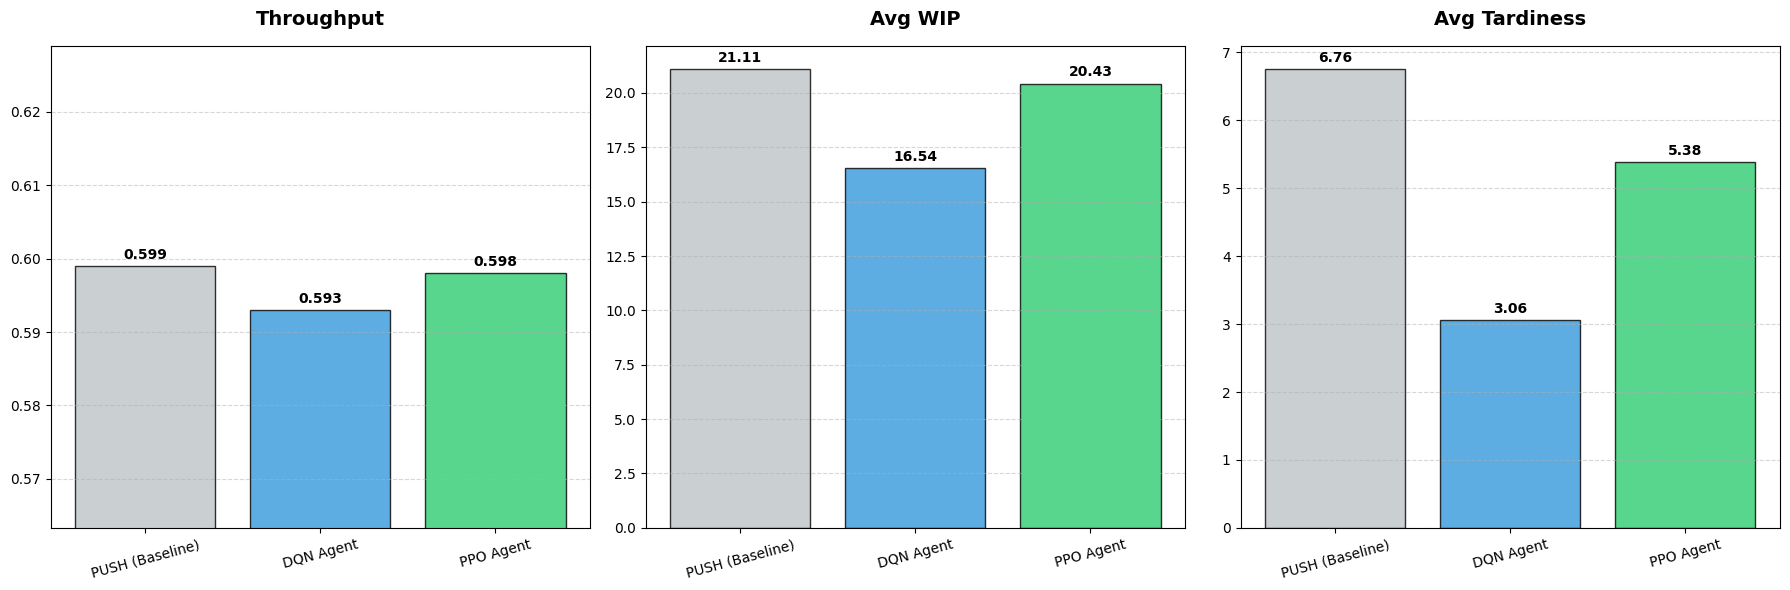

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_final_results(push, dqn, ppo):
    """
    Generates a professional comparison of three key metrics across
    different policies using dynamic data from the simulation.
    """
    # Define metrics and dynamic data labels
    metrics = ['Throughput', 'Avg WIP', 'Avg Tardiness']
    labels = ['PUSH (Baseline)', 'DQN Agent', 'PPO Agent']
    colors = ['#bdc3c7', '#3498db', '#2ecc71'] # Gray, Blue, Green

    # Create a figure with 3 horizontal subplots for clear metric separation
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Iterate through metrics to generate individual charts
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Map metric names to the dictionary keys used in the simulation stats
        if metric == 'Throughput':
            data = [push['throughput'], dqn['throughput'], ppo['throughput']]
            fmt = '{:.3f}'
            # Zoom in on throughput to highlight subtle improvements/stability
            ax.set_ylim(min(data)*0.95, max(data)*1.05)
        elif metric == 'Avg WIP':
            data = [push['avg_wip'], dqn['avg_wip'], ppo['avg_wip']]
            fmt = '{:.2f}'
        else: # Avg Tardiness
            data = [push['avg_tardiness'], dqn['avg_tardiness'], ppo['avg_tardiness']]
            fmt = '{:.2f}'

        # Create bar chart with professional aesthetics
        bars = ax.bar(labels, data, color=colors, edgecolor='black', alpha=0.8)

        # Add data labels on top of each bar for immediate readability
        for bar in bars:
            height = bar.get_height()
            ax.annotate(fmt.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

        ax.set_title(metric, fontweight='bold', size=14, pad=15)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.tick_params(axis='x', rotation=15) # Rotate x-labels for better fit

    plt.tight_layout()

    # Save the final high-resolution figure for the GitHub repository
    plt.savefig('detailed_results.png', dpi=300)
    plt.show()

# Automatically execute the plotting function using current session results
plot_final_results(push_stats, dqn_stats, ppo_stats)